In [1]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

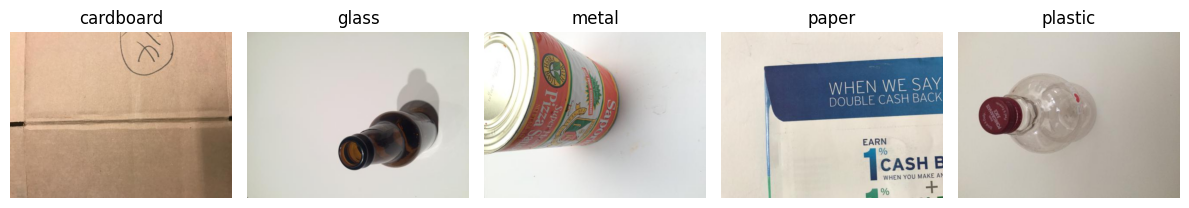

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
dataset_dir = r"D:\AICTE INTERNSHIP\projectdataset\TrashType_Image_Dataset"
class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
plt.figure(figsize=(12, 6))

for i, class_name in enumerate(class_folders[:5]):
    class_path = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_path)
    if not image_files:
        continue
    image_path = os.path.join(class_path, image_files[0])
    image = Image.open(image_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [3]:
image_size=(160,160)
batchsize=32
seed=42


In [4]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    shuffle=True,
    image_size=image_size,
    batch_size=batchsize,
    seed=42,
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [5]:
test_ds=tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    image_size=image_size,
    batch_size=batchsize,
    seed=42,
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [6]:
val_batches=tf.data.experimental.cardinality(test_ds)
oneval=test_ds.take(val_batches//2)
twoval=test_ds.skip(val_batches//2)

In [7]:
print(train_ds.class_names)
print(test_ds.class_names)
print("No.of Classses are ",len(test_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
No.of Classses are  6


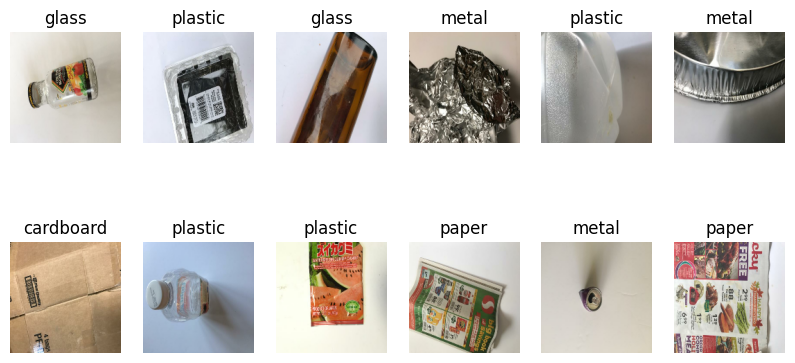

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [9]:
def count_distribution(dataset,names):
    total=0
    counts={name:0 for name in names}
    for _,labels in dataset:
        for i in labels.numpy():
            class_name=names[i]
            counts[class_name]+=1
            total+=1
    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  
    return counts
    

In [10]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [11]:
class_names=train_ds.class_names
train_dist=count_distribution(train_ds,class_names)
test_dist=count_distribution(test_ds,class_names)
oneval_dist=count_distribution(oneval,class_names)
twoval_dist=count_distribution(twoval,class_names)
print(train_dist)
print(test_dist)
print(oneval_dist)
print(twoval_dist)


{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 12.85, 'glass': 22.09, 'metal': 16.06, 'paper': 26.51, 'plastic': 17.27, 'trash': 5.22}


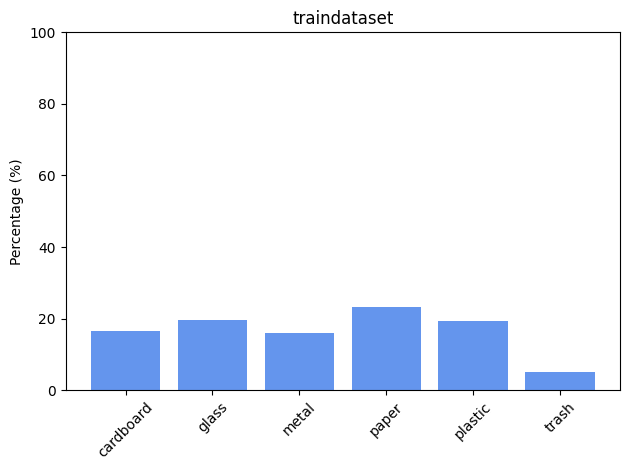

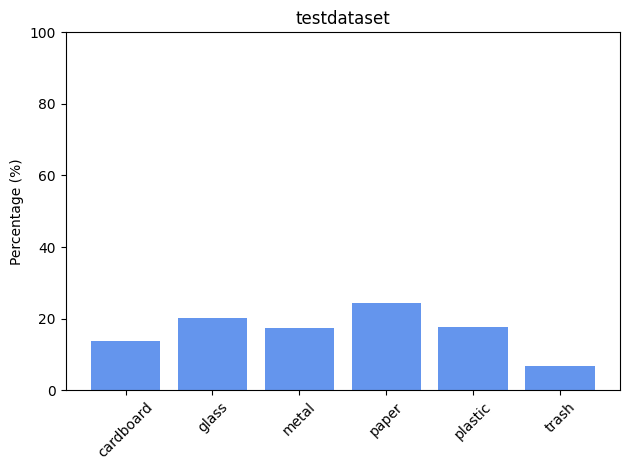

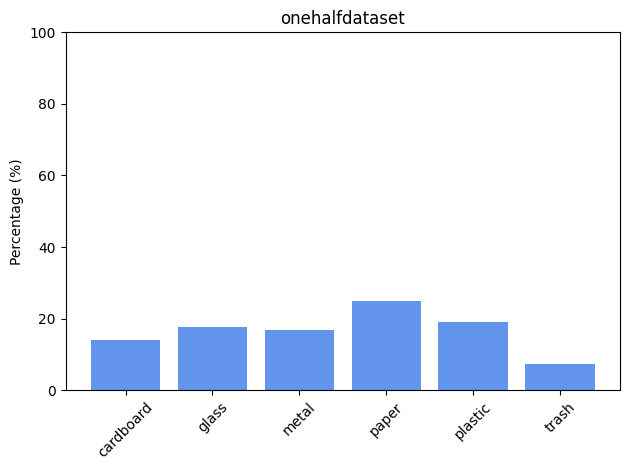

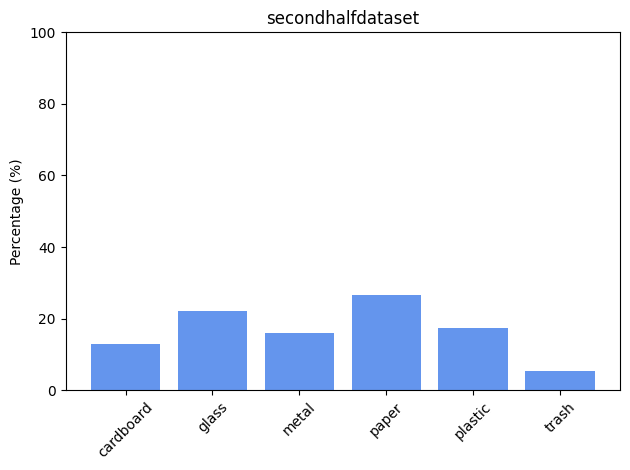

In [12]:
simple_bar_plot(train_dist,'traindataset')
simple_bar_plot(test_dist,'testdataset')
simple_bar_plot(oneval_dist,'onehalfdataset')
simple_bar_plot(twoval_dist,'secondhalfdataset')

In [16]:
class_counts={i:0 for i in range(len(class_names))}
alllabels=[]
for images,labels in train_ds:
    for label in labels.numpy():
        class_counts[label]+=1
        alllabels.append(label)
classweightsarray=compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=alllabels
)
classweights={x:w for x,w in enumerate(classweightsarray)}


In [18]:
print(classweights)
print(class_counts)

{0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}
{0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}


In [19]:

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [20]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:200]:
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [22]:
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  
])

In [23]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)